# It can be easy to hurt people when one get anonymous on social media or forums. 

These are the algorithm we will benchmark :
* **Naive Bayes**
* **SVM**
* **Tree Based Method**
* **Long Short Term Memory Neural Networks.**

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import log_loss


#NLP tools
import re
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
stopwords = nltk.corpus.stopwords.words('english')


#Plot and image tools
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style("dark")

train_data_path='../input/jigsaw-toxic-comment-classification-challenge/train.csv'

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

imagetc
jigsaw-toxic-comment-classification-challenge



In [2]:
#Loading the Data
train = pd.read_csv(train_data_path)
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')

# We have got 6 categories of undesirable comments :
1. Toxic
2. Severe Toxic
3. Obscene
4. Threat
5. Insult
6. Identity hate

In [3]:
#a quick look at our training dataset
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
# the size of our training dataset
train.shape

(159571, 8)

### We create a new cell for "clean" comments. Comments that correspond to none of the 6 categories.

In [5]:
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
train['clean'].sum()


143346

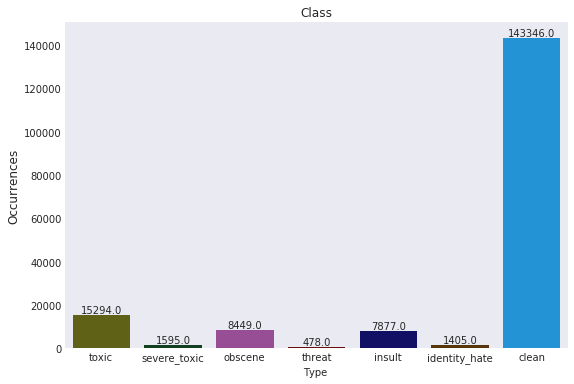

In [6]:
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=train.iloc[:,2:].sum()

plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values,palette=palette)
plt.title("Class")
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Type ')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, 
            ha='center', va='bottom')

plt.show()

In [7]:
# Just a list that contains all the text data. For me not to load the whole dataset everytime
comment_text_list = train.apply(lambda row : nltk.word_tokenize( row['comment_text']),axis=1)

In [8]:
#An odd comment contains a high rate of punctuation symbols or capital letters
rate_punctuation=0.7
rate_capital=0.7
def odd_comment(comment):
    punctuation_count=0
    capital_letter_count=0
    total_letter_count=0
    for token in comment:
        if token in list(string.punctuation):
            punctuation_count+=1
        capital_letter_count+=sum(1 for c in token if c.isupper())
        total_letter_count+=len(token)
    return((punctuation_count/len(comment))>=rate_punctuation or 
           (capital_letter_count/total_letter_count)>rate_capital)

odd=comment_text_list.apply(odd_comment)


In [9]:
odd_ones=odd[odd==True]
#list(ponctuation_polluted.index)
odd_comments=train.loc[list(odd_ones.index)]
odd_comments[odd_comments.clean==False].count()/len(odd_comments)

id               0.654298
comment_text     0.654298
toxic            0.654298
severe_toxic     0.654298
obscene          0.654298
threat           0.654298
insult           0.654298
identity_hate    0.654298
clean            0.654298
dtype: float64

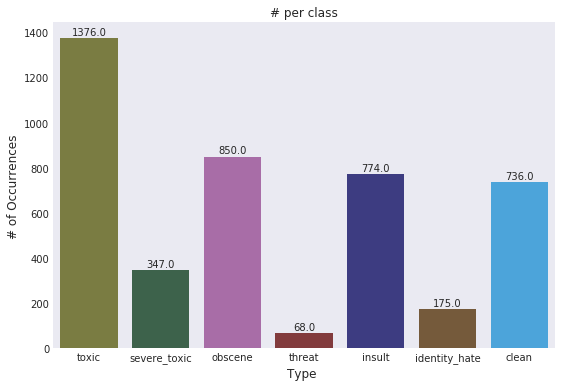

In [10]:
colors_list = ["brownish green", "pine green", "ugly purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=odd_comments.iloc[:,2:].sum()


plt.figure(figsize=(9,6))
ax= sns.barplot(x.index, x.values, alpha=0.8, palette=palette)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [11]:
# quick check for empty comments
empty_com=train[train.comment_text==""]
empty_com

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean


In [12]:
#quick check for duplicated comments
duplicate=train.comment_text.duplicated()
duplicate[duplicate==True]

Series([], Name: comment_text, dtype: bool)

In [13]:
#Just storing each categories of non clean comments in specific arrays
toxic=train[train.toxic==1]['comment_text'].values
severe_toxic=train[train.severe_toxic==1]['comment_text'].values
obscene=train[train.obscene==1]['comment_text'].values
threat=train[train.threat==1]['comment_text'].values
insult=train[train.insult==1]['comment_text'].values
identity_hate=train[train.identity_hate==1]['comment_text'].values

Wordclouds are a quick way to see which words are dominant in a text. We can even draw specific forms of cloud. Let's see which word are the most represented in toxic labeled comments

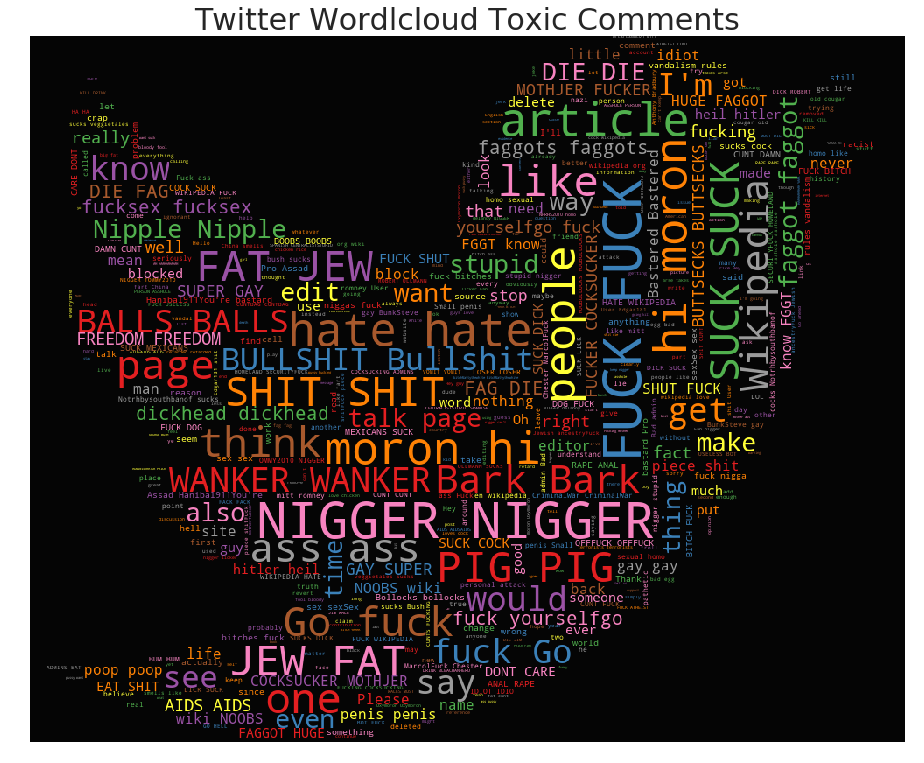

In [14]:
mask=np.array(Image.open('../input/imagetc/twitter.png'))
mask=mask[:,:,1]
from wordcloud import WordCloud, STOPWORDS
# The wordcloud of Toxic Comments
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=500,mask=mask 
             , stopwords=stopwords, max_font_size= 60)
wc.generate(" ".join(toxic))
plt.title("Twitter Wordlcloud Toxic Comments", fontsize=30)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Set1' , random_state=1), alpha=0.98)
plt.axis('off')
plt.savefig('twitter_wc.png')

### Till now we have worked with raw text. Let's do some text processing now
### We are gonna Lemmatize every word we have.
Lemmatization uses context and part of speech to determine the inflected form of the word and applies different normalization rules for each part of speech to get the root word (lemma). 
For instance : Lemmatization(drank)=drink

### We also replace some apostrophe words like "won't" ==> will not, "can't"==> cannot..
### Let's begin with the toxic category

In [15]:


replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would')
]
class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
         self.patterns = [(re.compile(regex), repl) for (regex, repl) in
         patterns]
     
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
             s = re.sub(pattern, repl, s)
        return s

In [16]:
from nltk.stem import WordNetLemmatizer
lemmer = WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import TweetTokenizer
#from replacers import RegexpReplacer
replacer = RegexpReplacer()
tokenizer=TweetTokenizer()

def comment_process(category):
    category_processed=[]
    for i in range(category.shape[0]):
        comment_list=tokenizer.tokenize(replacer.replace(category[i]))
        comment_list_cleaned= [word for word in comment_list if ( word.lower() not in stopwords 
                              and word.lower() not in list(string.punctuation) )]
        comment_list_lemmed=[lemmer.lemmatize(word, 'v') for word in comment_list_cleaned]
        category_processed.extend(list(comment_list_lemmed))
    return category_processed


In [17]:
toxic1=comment_process(toxic)

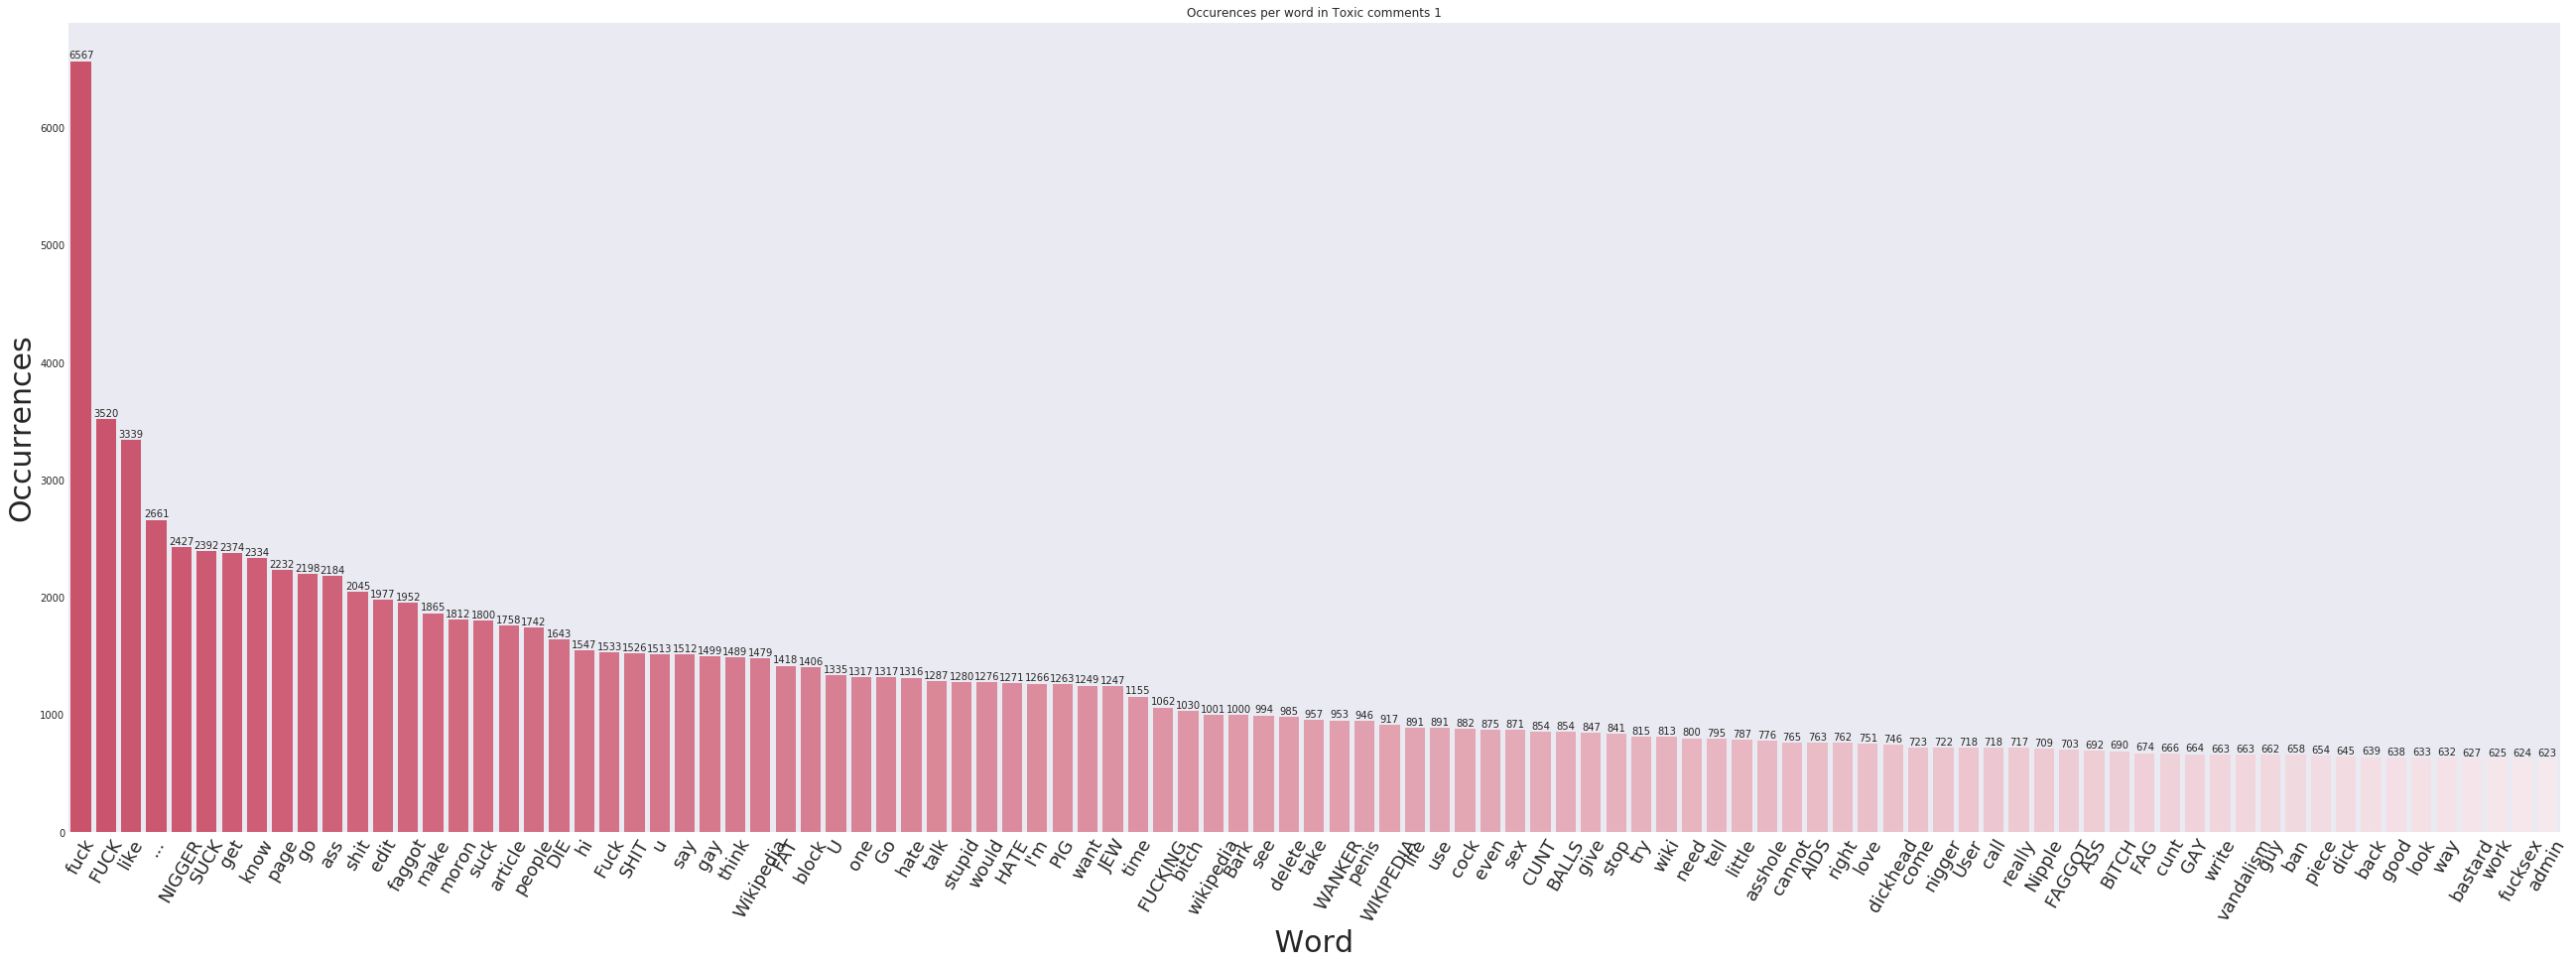

In [18]:
fd=nltk.FreqDist(word for word in toxic1)

x=[fd.most_common(150)[i][0] for i in range(99)]
y=[fd.most_common(150)[i][1] for i in range(99)]
#palette=sns.color_palette("PuBuGn_d",100)
palette= sns.light_palette("crimson",100,reverse=True)
plt.figure(figsize=(45,15))
ax= sns.barplot(x, y, alpha=0.8,palette=palette)
plt.title("Occurences per word in Toxic comments 1")
plt.ylabel('Occurrences', fontsize=30)
plt.xlabel(' Word ', fontsize=30)
#adding the text labels
rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.xticks(rotation=60, fontsize=18)
#plt.savefig('Toxic_Word_count1.png')    
plt.show()




 You can open that plot in a new window to see it bigger ;)
### We see that some words have lots of occurences whereas we  did not even see them on the first wordcloud. Using the word cloud library on unprocessed data may be misleading. Let's do draw the same barplot without lemmatization and stemming

In [19]:
toxic2=[]
for i in range(toxic.shape[0]):
    comment_list=nltk.word_tokenize(toxic[i])
    comment_list_cleaned= [word for word in comment_list if ( word.lower() not in stopwords 
                          and word.lower() not in list(string.punctuation) )]
    toxic2.extend(list(set(comment_list_cleaned)))

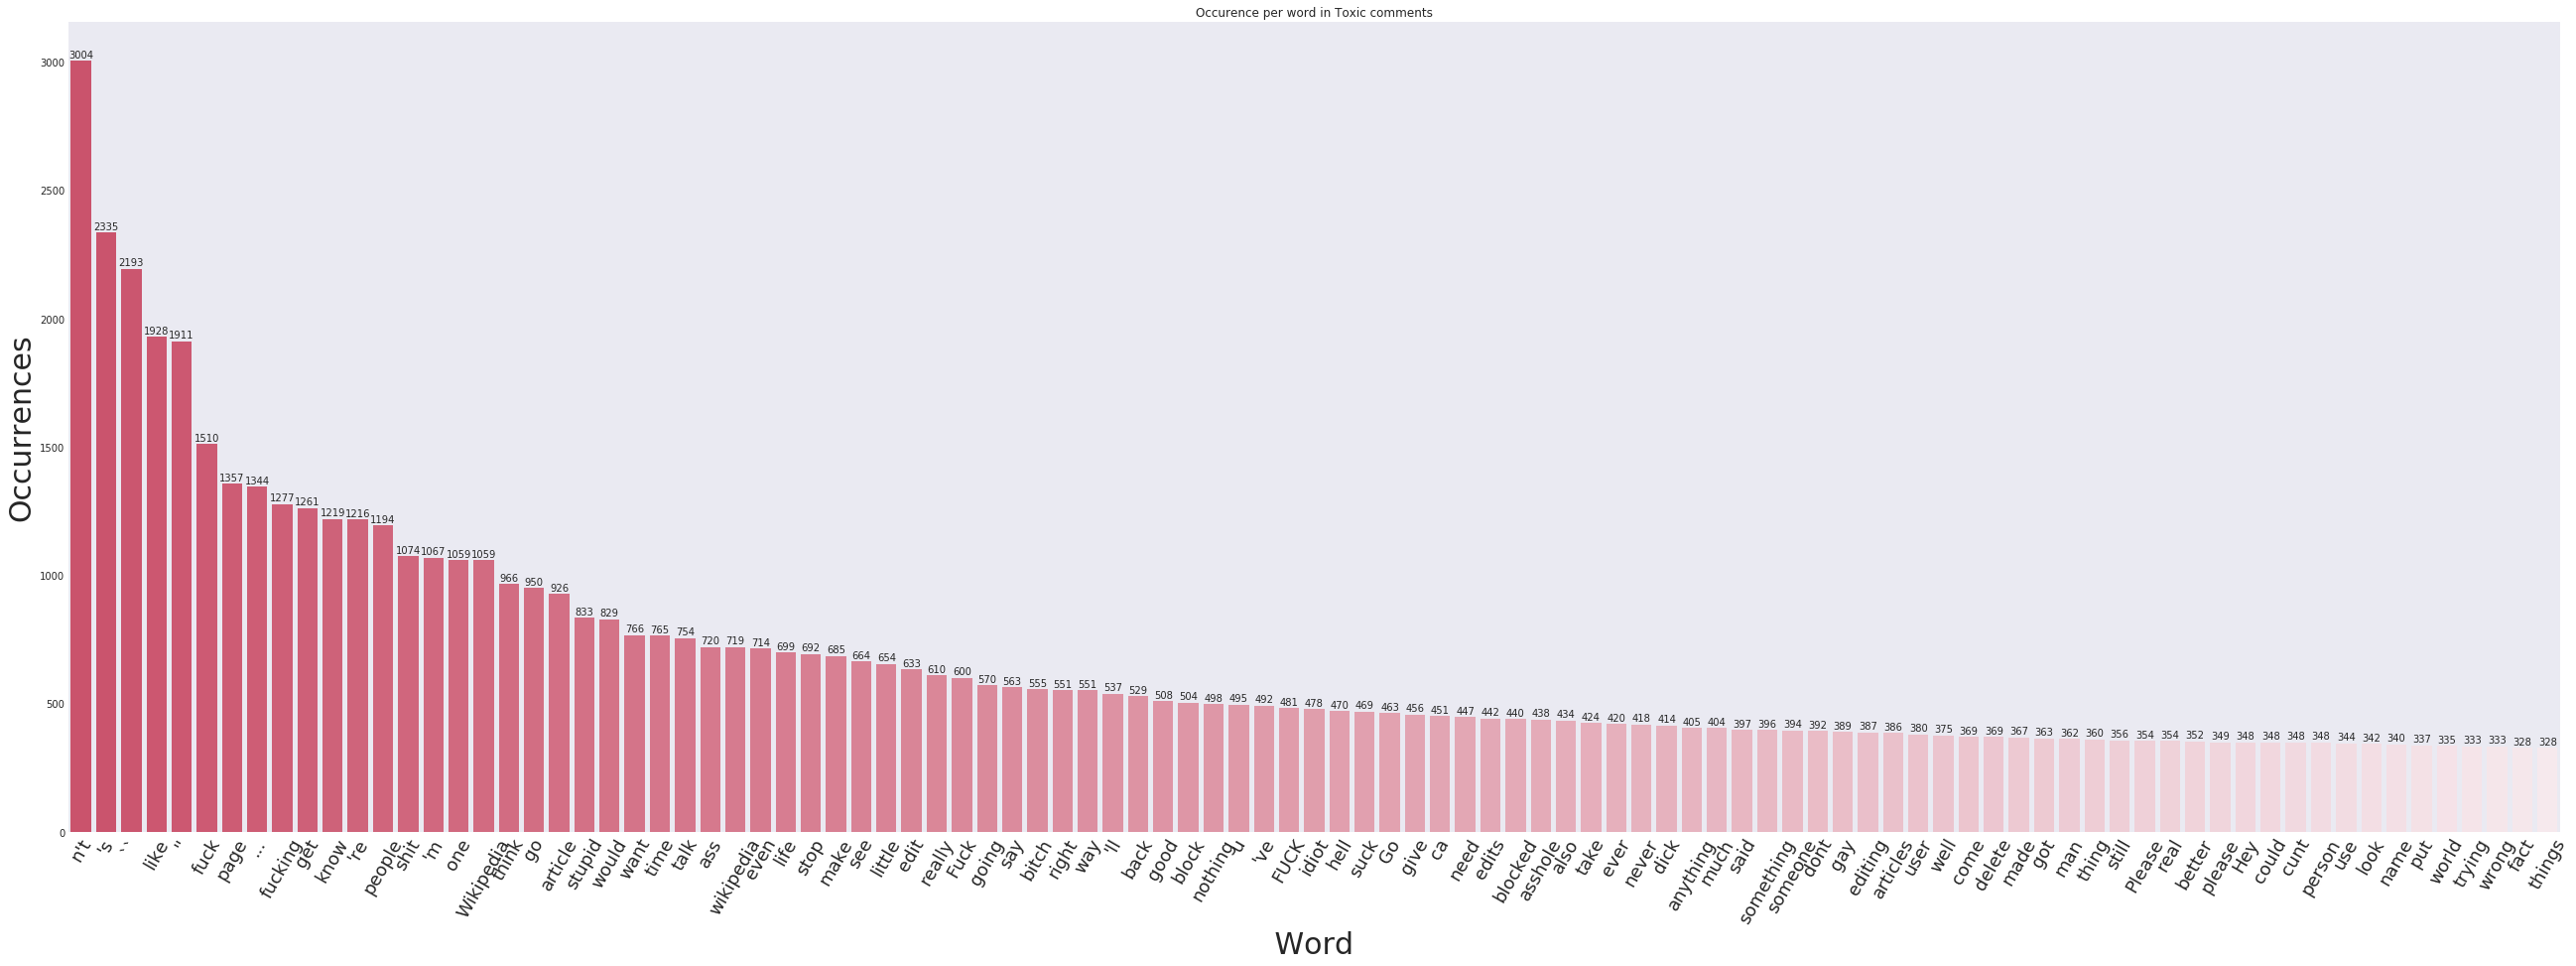

In [20]:
fd2=nltk.FreqDist(word for word in toxic2)
x=[fd2.most_common(100)[i][0] for i in range(99)]
y=[fd2.most_common(100)[i][1] for i in range(99)]
palette= sns.light_palette("crimson",100,reverse=True)
plt.figure(figsize=(45,15))
ax= sns.barplot(x, y, alpha=0.8,palette=palette)
plt.title("Occurence per word in Toxic comments")
plt.ylabel('Occurrences', fontsize=30)
plt.xlabel(' Word ', fontsize=30)

rects = ax.patches
labels = y
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.xticks(rotation=60, fontsize=18)
#plt.savefig('Toxic_Word_count2.png')    
plt.show()
#Check the bigger picture in imagetc files 

### Without Lemmatization, the roots of words can be separated in different bars. So we won't use this processed data

True

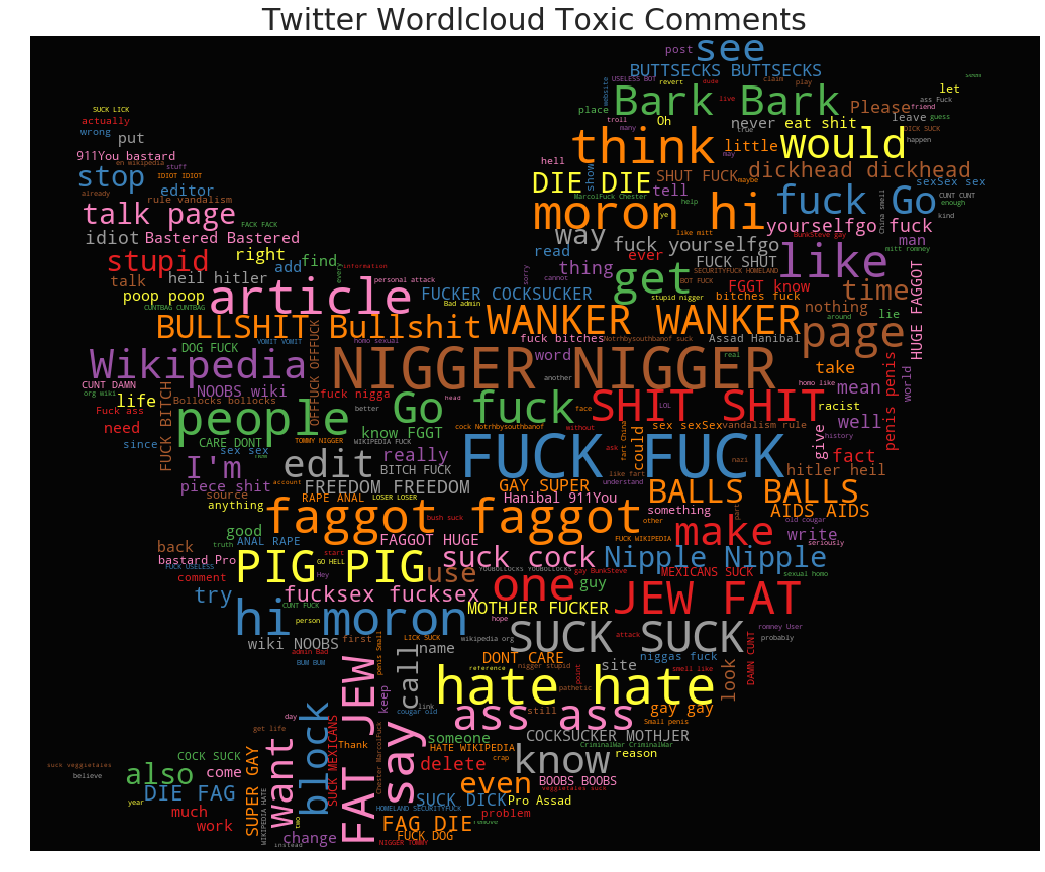

In [21]:
def wordcloud_plot(category, name) : 
    plt.figure(figsize=(20,15))
    wc = WordCloud(background_color="black", max_words=500,mask=mask, min_font_size=6 
                 , stopwords=stopwords, max_font_size= 60)
    wc.generate(" ".join(category))
    plt.title("Twitter Wordlcloud " + name +  " Comments", fontsize=30)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Set1' , random_state=21), alpha=0.98)
    plt.axis('off')
    plt.savefig(name+'_wc.png')
    return(True)

wordcloud_plot(toxic1,'Toxic')

### This final Word Cloud is very different to the first one. And this one is more coherent compared to the barplot. Now we are going to draw the wordclouds for each categories.

In [22]:
severe_toxic1=comment_process(severe_toxic)
obscene1=comment_process(obscene)
threat1=comment_process(threat)
insult1=comment_process(insult)
identity_hate1=comment_process(identity_hate)

True

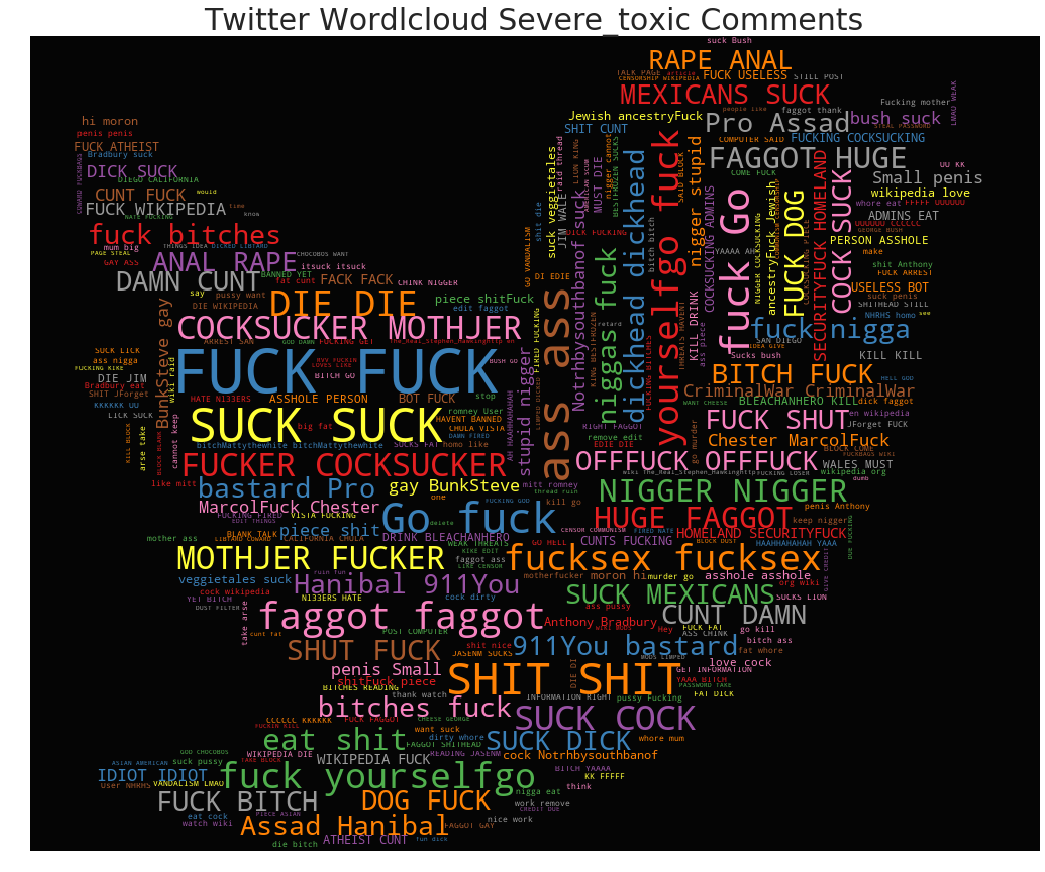

In [23]:
wordcloud_plot(severe_toxic1,'Severe_toxic')

True

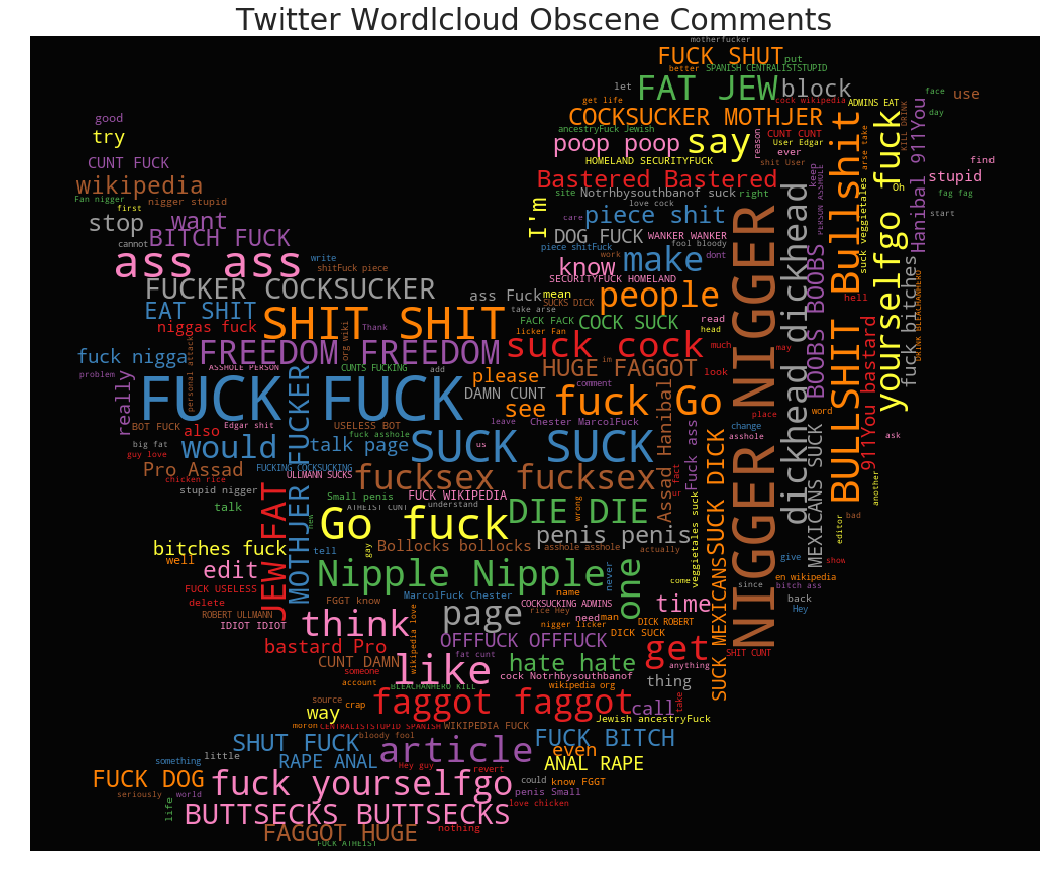

In [24]:
wordcloud_plot(obscene1,'Obscene')

True

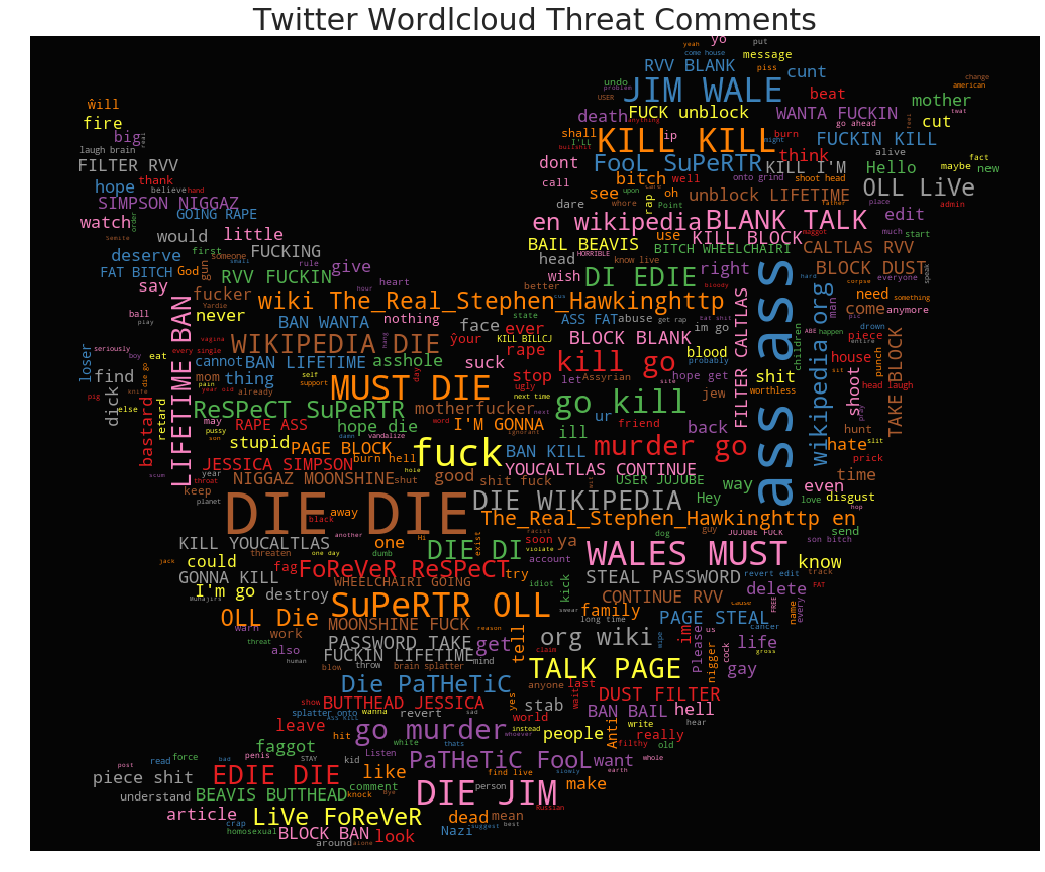

In [25]:
wordcloud_plot(threat1,'Threat')

True

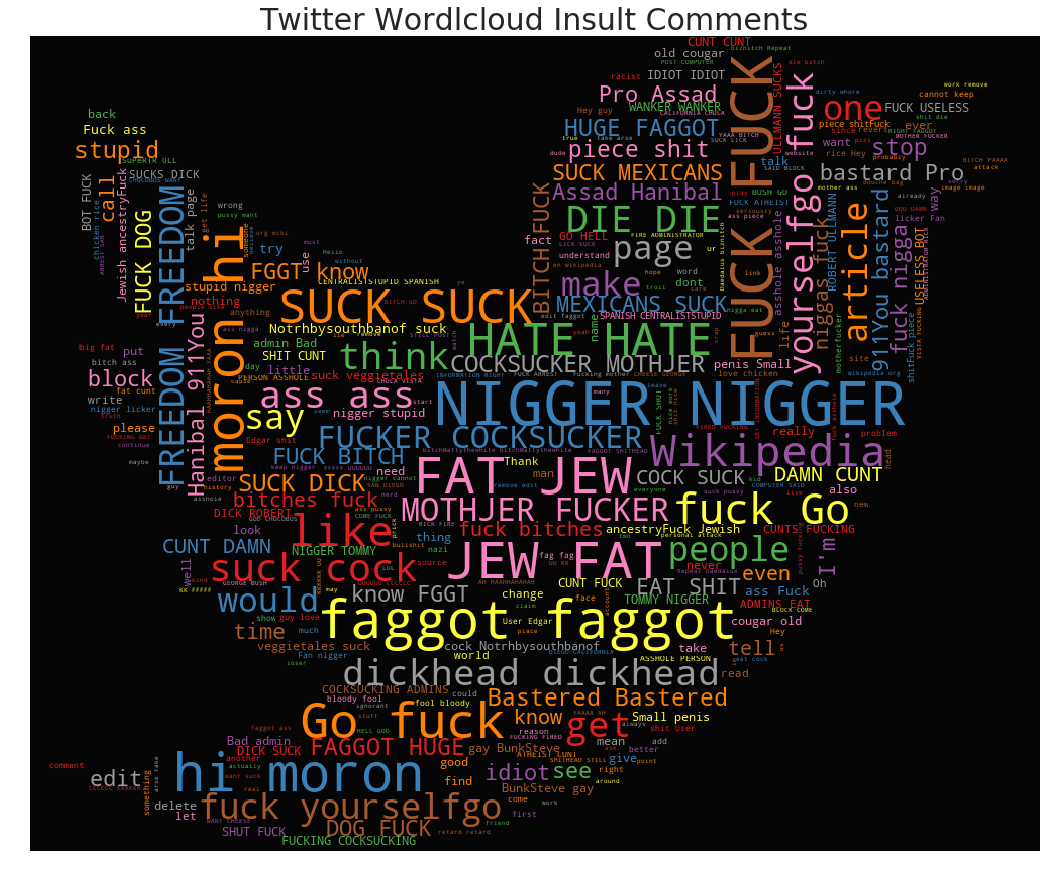

In [26]:
wordcloud_plot(insult1,'Insult')

True

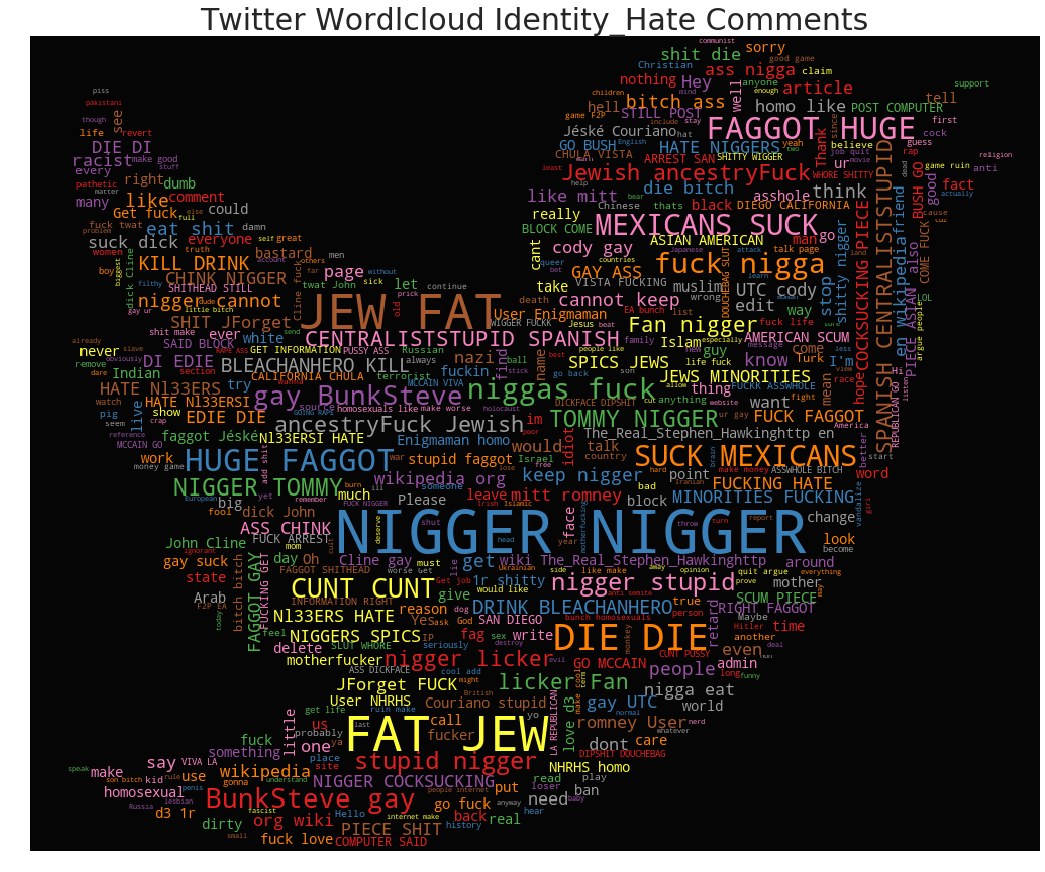

In [27]:
wordcloud_plot(identity_hate1,'Identity_Hate')

### From all those plots we conclude that :
Some categories share the same vocabulary in term of richness and word frequency, like Insult and Toxic categories. And some others, like Identity Hate category, use specific words more frequently. I let you check that for yourself. 
We could try to find the words that are specific to each category to create a new feature but the TF-IDF trick will do that for us.

### Let's Tackle the problem of length


In [28]:
toxic3=train[train.clean==False]['comment_text']
toxic3
toxic_count_word=toxic3.apply(lambda x: len(str(x).split()))
print(toxic_count_word.describe(),'\n \n',toxic_count_word.quantile(q=0.9))

count    16225.000000
mean        52.717720
std        106.854731
min          2.000000
25%         11.000000
50%         23.000000
75%         50.000000
max       1411.000000
Name: comment_text, dtype: float64 
 
 106.0


In [29]:
clean3=train[train.clean==True]['comment_text']
clean_count_word=clean3.apply(lambda x: len(str(x).split()))
print(clean_count_word.describe(), clean_count_word.quantile(q=0.9))

count    143346.000000
mean         68.921065
std          98.195083
min           1.000000
25%          18.000000
50%          38.000000
75%          78.000000
max        1250.000000
Name: comment_text, dtype: float64 156.0


It seems like we will not use the number of word in comments as a features. The variance for clean and non clean comment is too big and their distribution overlap each other. :(

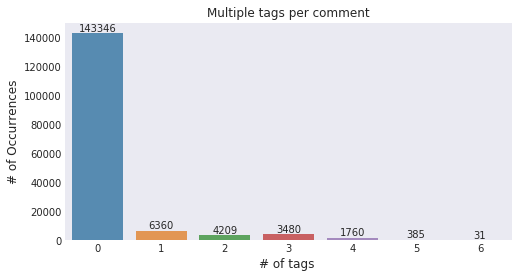

In [30]:
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

One could think that the comments with more label may be longer. But it's not even the case...

Another Kaggler, Jagan, proposed to identify spam comments by their percentage of unique word. Great idea !

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


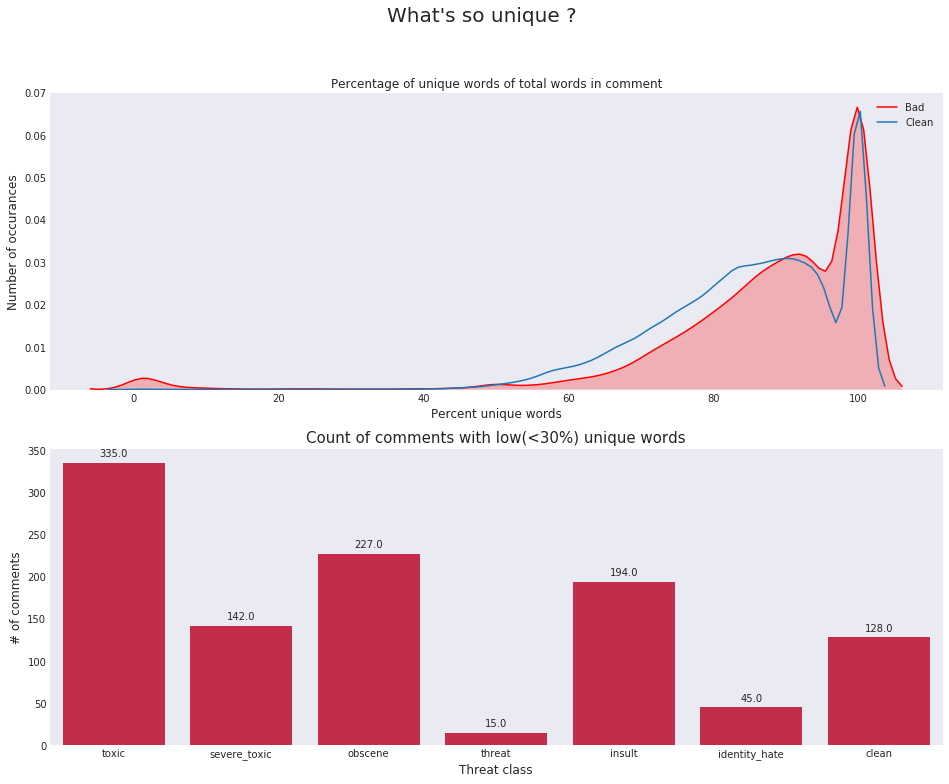

In [31]:
#Credit Jagan

train['count_unique_word']=train["comment_text"].apply(lambda x: len(set(str(x).split())))
train['count_word']=train["comment_text"].apply(lambda x: len(str(x).split()))
train['word_unique_percent']=train['count_unique_word']*100/train['count_word']
spammers=train[train['word_unique_percent']<30]

plt.figure(figsize=(16,12))
plt.suptitle("What's so unique ?",fontsize=20)
#gridspec.GridSpec(2,1)


plt.subplot2grid((2,1),(0,0))
plt.title("Percentage of unique words of total words in comment")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train[train.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train[train.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('Number of occurances', fontsize=12)
plt.xlabel('Percent unique words', fontsize=12)

x=spammers.iloc[:,2:9].sum()
plt.subplot2grid((2,1),(1,0),colspan=2)
plt.title("Count of comments with low(<30%) unique words",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color='crimson')

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

# And as espected, spams are more toxic
We will train another specific model for spams.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer( strip_accents='unicode',analyzer='word',ngram_range=(1,1),
            use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')
"""tf = TfidfVectorizer(min_df=100,  max_features=100000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1)"""

"tf = TfidfVectorizer(min_df=100,  max_features=100000, \n            strip_accents='unicode', analyzer='word',ngram_range=(1,1),\n            use_idf=1,smooth_idf=1,sublinear_tf=1)"

In [33]:
def category_to_tfidf(category):
    tvec_weights = tf.fit_transform(category)
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tf.get_feature_names(), 'weight': weights})
    return(weights_df.sort_values(by='weight', ascending=False).head(10))



In [34]:
toxic_idf=category_to_tfidf(toxic1)
severe_toxic_idf=category_to_tfidf(severe_toxic1)
threat_idf=category_to_tfidf(threat1)
insult_idf=category_to_tfidf(insult1)
obscene_idf=category_to_tfidf(obscene1)
identity_hate_idf=category_to_tfidf(identity_hate1)
toxic_idf


,term,weight
11084,fuck,0.026908
25721,suck,0.009767
24072,shit,0.008288
16023,like,0.008268
29315,wikipedia,0.007847
18544,nigger,0.007502
2556,ass,0.006646
10014,faggot,0.006106
12622,hate,0.005971
19623,page,0.005795


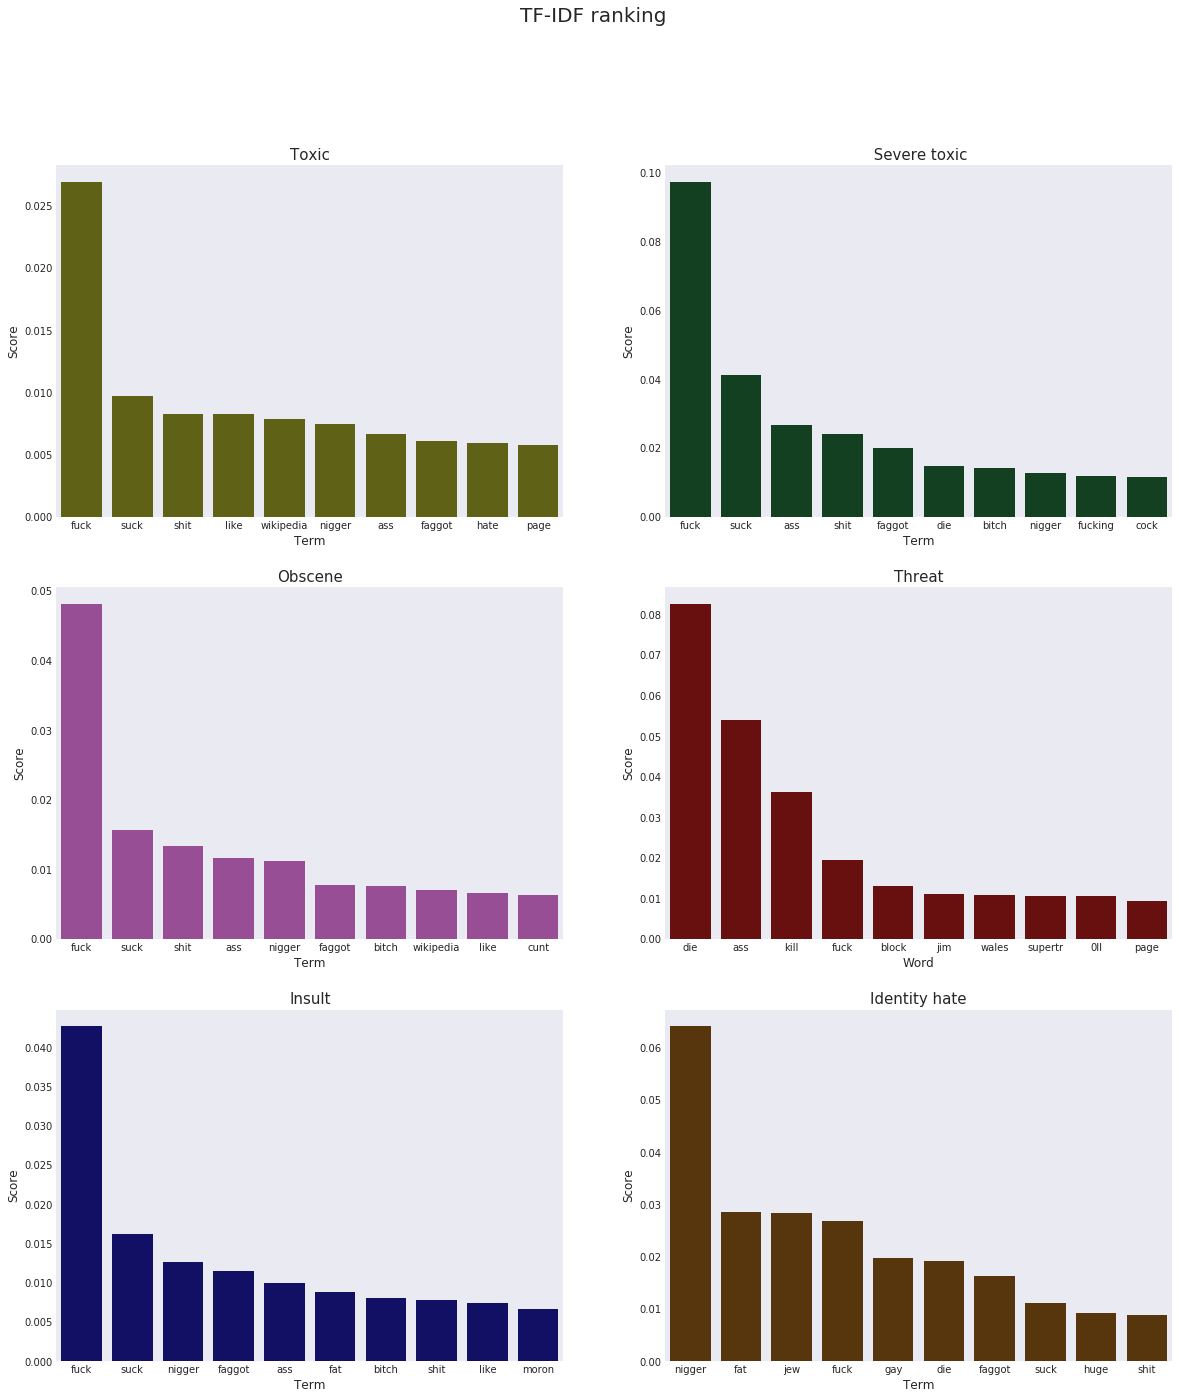

In [35]:
color_list = ["xkcd:brownish green", "xkcd:pine green", "xkcd:ugly purple",
               "xkcd:blood", "xkcd:deep blue", "xkcd:brown"]
plt.figure(figsize=(20,22))
plt.suptitle("TF-IDF ranking ",fontsize=20)
gridspec.GridSpec(3,2)
plt.subplot2grid((3,2),(0,0))
sns.barplot(toxic_idf.term,
            toxic_idf.weight,color=color_list[0])
plt.title("Toxic",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)

plt.subplot2grid((3,2),(0,1))
sns.barplot(severe_toxic_idf.term,
            severe_toxic_idf.weight,color=color_list[1])
plt.title(" Severe toxic",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(1,0))
sns.barplot(obscene_idf.term,
            obscene_idf.weight,color=color_list[2])
plt.title("Obscene",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(1,1))
sns.barplot(threat_idf.term,
            threat_idf.weight,color=color_list[3])
plt.title("Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(2,0))
sns.barplot(insult_idf.term,
            insult_idf.weight,color=color_list[4])
plt.title("Insult",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.subplot2grid((3,2),(2,1))
sns.barplot(identity_hate_idf.term,
            identity_hate_idf.weight,color=color_list[5])
plt.title("Identity hate",fontsize=15)
plt.xlabel('Term', fontsize=12)
plt.ylabel('Score', fontsize=12)


plt.show()